## Import Libraries

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
from copy import deepcopy

## Parameters

In [3]:
num_rounds = 20
num_clients = 100
client_fraction = 0.01
local_epochs = 1
learning_rate = 0.001

## Load MNIST dataset

In [4]:
def load_dataset_and_loaders():
    # Define transformations to normalize the data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    # Load the MNIST dataset
    train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Number of users
    num_users = num_clients
    
    # Size of data per user
    samples_per_user = len(train_data) // num_users 
    
    # Create a dictionary to store the indices for each user
    user_data = {i: [] for i in range(num_users)}
    
    # Shuffle the indices of the dataset to create a random split
    indices = np.arange(len(train_data))
    np.random.seed(10)
    np.random.shuffle(indices)
    
    for i in range(num_users):
        user_data[i] = indices[i * samples_per_user: (i + 1) * samples_per_user]
    
    # Create a DataLoader for each user
    train_loaders = []
    batch_size = 32
    
    for i in range(num_users):
        # Create a subset of the dataset for each user
        user_subset = Subset(train_data, user_data[i])
        # Create a DataLoader for each subset
        user_loader = DataLoader(user_subset, batch_size=batch_size, shuffle=True)
        train_loaders.append(user_loader)
    
    # Test DataLoader for evaluating the global model
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

    return train_loaders, test_loader, train_data, user_data

## Check Non-IID

In [5]:
# Plot class distributions for each user
def plot_class_distribution(user_class_counts):
    num_users = len(user_class_counts)
    fig, axs = plt.subplots(num_users // 4, 4, figsize=(20, 10))  # Adjust subplot layout for readability

    for i, (user, counts) in enumerate(user_class_counts.items()):
        ax = axs[i // 4, i % 4]
        ax.bar(range(10), counts)
        ax.set_title(f'User {user}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Number of Samples')
        ax.set_xticks(range(10))

    plt.tight_layout()
    plt.show()

In [6]:
# Function to calculate class distribution for each user
def calculate_and_plot_class_distribution(data, user_data):
    user_class_counts = defaultdict(lambda: np.zeros(10, dtype=int))  # Initialize counts for 10 classes

    # Iterate over each user
    for user, indices in user_data.items():
        # Count the classes for each user's subset of indices
        for idx in indices:
            label = data.targets[idx].item()  # Get the label of the sample
            user_class_counts[user][label] += 1

    # Display the class distribution for each user
    for user, counts in user_class_counts.items():
        print(f"User {user}: {counts}")

    plot_class_distribution(user_class_counts)

## Define Our Deep Neural Network

In [7]:
# Define the CNN Model with 2 convolutional layers and 2 fully-connected layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = SimpleCNN()


## Define Functions for Local Training and Model Evaluation

In [8]:
def train_local(model, train_loader, epochs=1, lr=0.01):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return model.state_dict()


In [9]:
# Function to test the global model on test data
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

## Implement FedAvg

In [10]:
# Function to average weights from selected clients
def average_weights(selected_models):
    avg_state_dict = deepcopy(selected_models[0].state_dict())
    
    # Iterate through each parameter in the state dict
    for key in avg_state_dict.keys():
        for model in selected_models[1:]:
            avg_state_dict[key] += model.state_dict()[key]
        avg_state_dict[key] = avg_state_dict[key] / len(selected_models)

    return avg_state_dict

In [11]:
# Federated training function with client fraction C and test accuracy measurement
def federated_training(num_rounds, num_clients, client_fraction, local_epochs, train_loaders, test_loader, lr=0.001):
    # Initialize the global model
    global_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    # Set global model to training mode
    global_model.train()

    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    accuracies = []

    for round_num in range(num_rounds):
        print(f"\nStarting round {round_num + 1}/{num_rounds}")

        # Select a fraction of clients
        num_selected_clients = max(1, int(client_fraction * num_clients))
        selected_clients = random.sample(range(num_clients), num_selected_clients)

        selected_models = []

        for client_id in selected_clients:
            # Clone the global model for local training
            local_model = deepcopy(global_model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=lr)

            # Train the local model
            local_model.train()
            for epoch in range(local_epochs):
                for batch in train_loaders[client_id]:
                    inputs, labels = batch
                    local_optimizer.zero_grad()
                    outputs = local_model(inputs) #데이터 예측 forward pass
                    loss = criterion(outputs, labels) #예측값 라벨 간 차이 계산
                    loss.backward() #loss에 따른 모델 weight gradient 계산
                    local_optimizer.step()

            # Add the trained local model to the list
            selected_models.append(local_model)

        # Aggregate the weights of selected models
        global_model.load_state_dict(average_weights(selected_models))

        # Test the global model
        global_model.eval() #평가모드 불필요한 연산 방지
        correct, total = 0, 0
        with torch.no_grad(): #gradient 계산하지않음
            for inputs, labels in test_loader:
                outputs = global_model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return global_model, accuracies

User 0: [59 68 65 58 52 52 62 78 45 61]
User 1: [51 69 55 50 71 54 61 73 55 61]
User 2: [58 63 64 52 56 58 62 64 65 58]
User 3: [59 72 65 57 57 58 47 63 62 60]
User 4: [59 82 53 45 55 63 78 73 52 40]
User 5: [55 64 66 61 67 56 52 68 57 54]
User 6: [46 64 66 74 58 48 55 78 49 62]
User 7: [59 66 57 55 46 66 49 67 72 63]
User 8: [51 71 78 54 68 47 62 66 52 51]
User 9: [57 61 55 67 65 63 51 64 71 46]
User 10: [43 53 80 59 61 55 63 62 66 58]
User 11: [69 73 51 63 55 52 55 60 56 66]
User 12: [56 63 75 63 64 47 59 75 43 55]
User 13: [49 58 57 70 68 49 65 71 49 64]
User 14: [51 57 55 63 53 64 80 66 66 45]
User 15: [64 74 56 52 70 59 52 61 60 52]
User 16: [62 70 63 58 53 48 60 63 67 56]
User 17: [61 68 60 73 54 62 52 57 62 51]
User 18: [51 82 59 52 63 58 77 54 53 51]
User 19: [67 67 61 56 64 45 59 73 52 56]
User 20: [62 74 59 66 64 42 66 55 56 56]
User 21: [59 69 68 60 65 54 64 47 52 62]
User 22: [72 66 43 66 60 53 46 74 63 57]
User 23: [63 61 63 65 51 53 49 75 64 56]
User 24: [66 58 66 82 46 5

/var/folders/3j/d9397my90xzbkwq4h0xby9mw0000gn/T/ipykernel_42998/1445160173.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


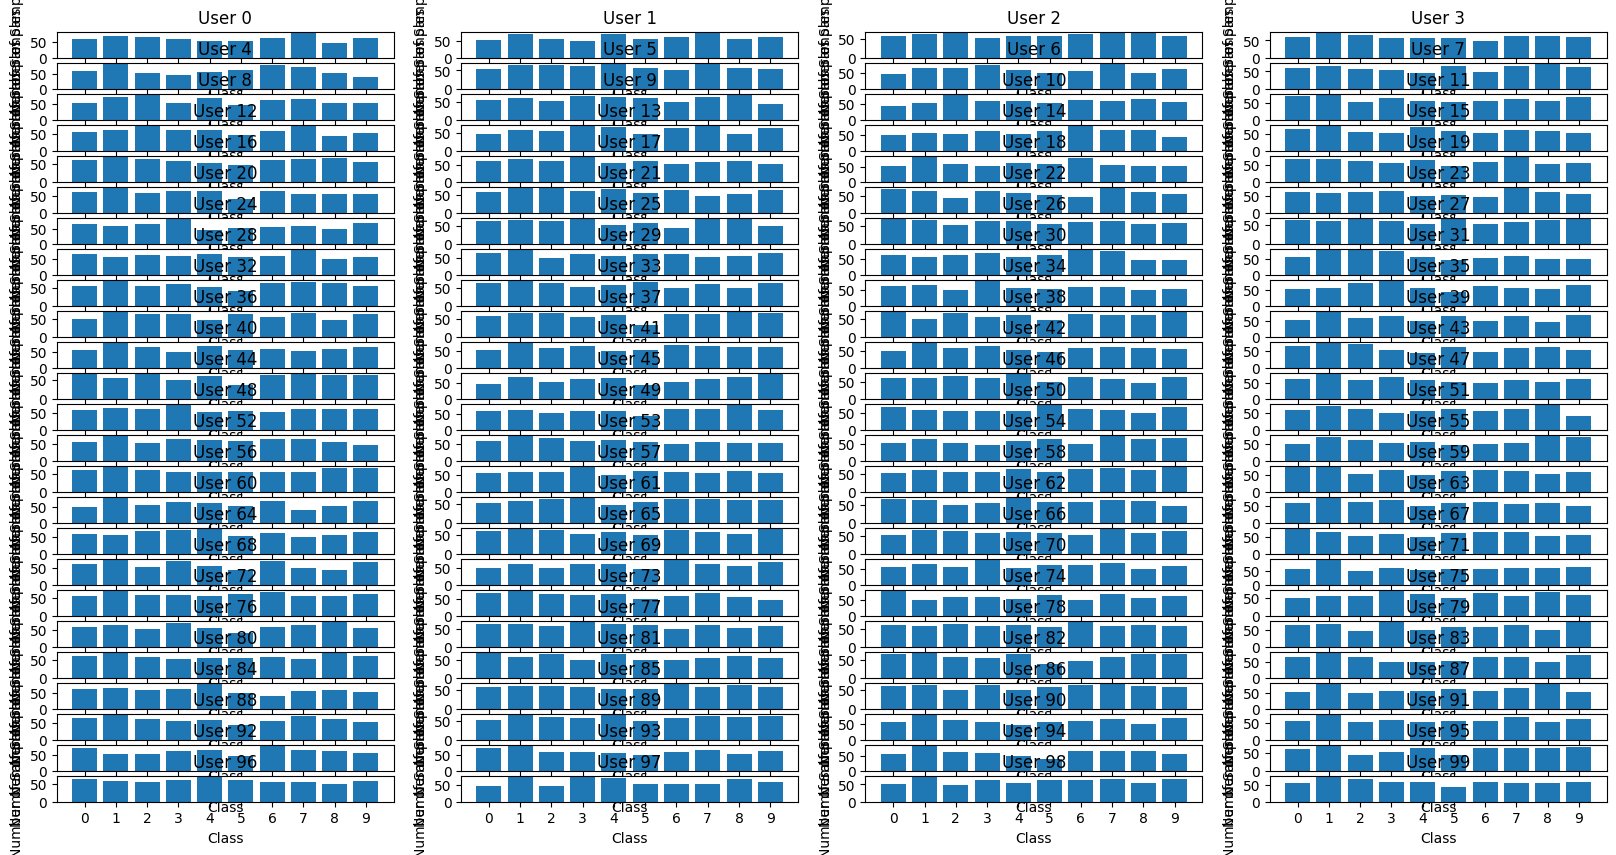


Starting round 1/20
Round 1 Accuracy: 11.83%

Starting round 2/20
Round 2 Accuracy: 15.07%

Starting round 3/20
Round 3 Accuracy: 18.94%

Starting round 4/20
Round 4 Accuracy: 24.43%

Starting round 5/20
Round 5 Accuracy: 31.24%

Starting round 6/20
Round 6 Accuracy: 36.69%

Starting round 7/20
Round 7 Accuracy: 40.69%

Starting round 8/20
Round 8 Accuracy: 44.48%

Starting round 9/20
Round 9 Accuracy: 47.52%

Starting round 10/20
Round 10 Accuracy: 50.61%

Starting round 11/20
Round 11 Accuracy: 53.21%

Starting round 12/20
Round 12 Accuracy: 54.27%

Starting round 13/20
Round 13 Accuracy: 55.16%

Starting round 14/20
Round 14 Accuracy: 58.14%

Starting round 15/20
Round 15 Accuracy: 58.40%

Starting round 16/20
Round 16 Accuracy: 61.32%

Starting round 17/20
Round 17 Accuracy: 63.61%

Starting round 18/20
Round 18 Accuracy: 63.10%

Starting round 19/20
Round 19 Accuracy: 63.86%

Starting round 20/20
Round 20 Accuracy: 63.34%


In [12]:
if __name__ == "__main__":
    train_loaders, test_loader, train_data, user_data = load_dataset_and_loaders()
    calculate_and_plot_class_distribution(train_data, user_data)
    global_model = federated_training(num_rounds, num_clients, client_fraction, local_epochs, train_loaders, test_loader, lr=learning_rate)
    